In [53]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 1. Loading the data

In [54]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]

label is 2


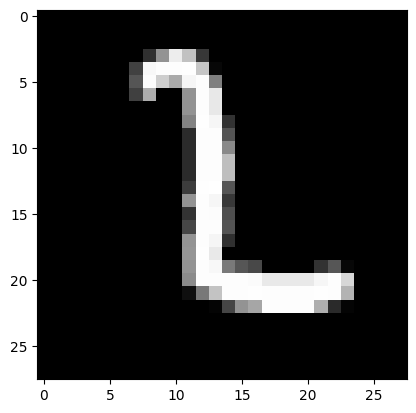

In [55]:
# exploring the data
i = np.random.randint(y_train.size)

print("label is", y_train[i])
plt.imshow(train_data[0][i], cmap='gray')

# 2. Building the model

We use Keras to build a fully-connected neural network.

For more details, see https://keras.io/guides/training_with_built_in_methods/

In [66]:
# source : https://keras.io/guides/training_with_built_in_methods/

def build_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(32, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
    return model

model = build_model()

#loss = keras.losses.sparse_categorical_crossentropy
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.summary()

Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ digits (InputLayer)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

## Question 4.1

For each layer, we count the number of optimization variables.

Input Layer:
* This layer has no parameter to train, so 0 optimization variable.

Layer 1:
* Input: 784
* Output: 32
* Each unit in the dense layer has a bias, so there are 32 biases.

Therefore, the total number of optimization varibles in this layer is 784 * 32 + 32 = 25 152.

Layer 2:
* Input: 32
* Output: 32
* 32 biases
Therefore, the total number of optimization variables in this layer is 32 * 32 + 32 = 1 024.

Output Layer (predictions):
* Input: 32
* Output: 10
* 10 biases

Therefore, the total number of optimization variables in this layer is 32 * 10 + 10 = 330.

Summing the parameters for all layers, we get the total number of optimization variables to be trained:

25 152 + 1 024 + 330 = 26 506.





In [57]:
# untrained model
predicted_probas = model(x_train)
y_pred = np.argmax(predicted_probas, 1) # the prediction is the class with highest probability
y_pred[0:30]

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5])

In [58]:
# what we would like to get
y_train[0:30]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7], dtype=uint8)

# 4. Computing gradients

We are now going to implement the stochastic gradient method using the Keras functionalities.

First, we need to understand how to compute gradients using auto-differentation (also called **backpropagation**).

In [59]:
# Source: https://keras.io/guides/writing_a_custom_training_loop_in_tensorflow/

# Example of gradient computation using automatic differentiation

# selecting a batch
x_train_batch = x_train[:8]
y_train_batch = y_train[:8]

# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.

        logits = model(x_train_batch)  # Logits for this minibatch (the logits are the name we give to the Neural Network output)

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


We also define two important helper functions.

In [60]:
## update the weights by adding real_factor * update
def update_weights(model, update, real_factor = 1.):
    new_weights = model.trainable_weights.copy()

    # iterate over all layers
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + real_factor * update[i]

    model.set_weights(new_weights)


# Evaluate model
def mean_loss(model, X, Y):
    logits = model(X)
    return np.mean(loss(Y, logits))

In [61]:
# evaluating the train loss on the whole dataset
# this is a costly operation, use sparsely
mean_loss(model, x_train, y_train)

2.331297

# 5. Training the model

## Question 5.1

In [62]:
# Stochastic gradient algorithm

# TO IMPLEMENT
def SGD(model, x_train, y_train, learning_rate, epochs=1, batch_size=1):

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        for i in range(0, len(x_train), batch_size):
            # Select the current batch
            x_train_batch = x_train[i:i+batch_size]
            y_train_batch = y_train[i:i+batch_size]

            # Open a GradientTape to record the operations
            with tf.GradientTape() as tape:
                logits = model(x_train_batch)
                loss_value = loss(y_train_batch, logits)

            # Compute the gradients
            grad = tape.gradient(loss_value, model.trainable_weights)

            # Update the weights using the gradients
            optimizer = keras.optimizers.SGD(learning_rate)
            optimizer.apply_gradients(zip(grad, model.trainable_variables))

        # Evaluate the model performance after each epoch
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {mean_loss(model, x_train, y_train)}')


## Question 5.2

According to theory, the best step size for stochastic gradient descent is 1/sqrt(k+1)

Epoch 1/1
Step 0/60000 - Loss: 2.2617874145507812


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Step 4000/60000 - Loss: 2.174304485321045
Step 8000/60000 - Loss: 1.9287378787994385
Step 12000/60000 - Loss: 1.7776830196380615
Step 16000/60000 - Loss: 1.8257478475570679
Step 20000/60000 - Loss: 1.5371445417404175
Step 24000/60000 - Loss: 1.2598257064819336
Step 28000/60000 - Loss: 0.9221107363700867
Step 32000/60000 - Loss: 0.9949408769607544
Step 36000/60000 - Loss: 1.115774393081665
Step 40000/60000 - Loss: 0.8200844526290894
Step 44000/60000 - Loss: 0.7071319818496704
Step 48000/60000 - Loss: 0.6451181173324585
Step 52000/60000 - Loss: 0.6868268847465515
Step 56000/60000 - Loss: 0.48616287112236023


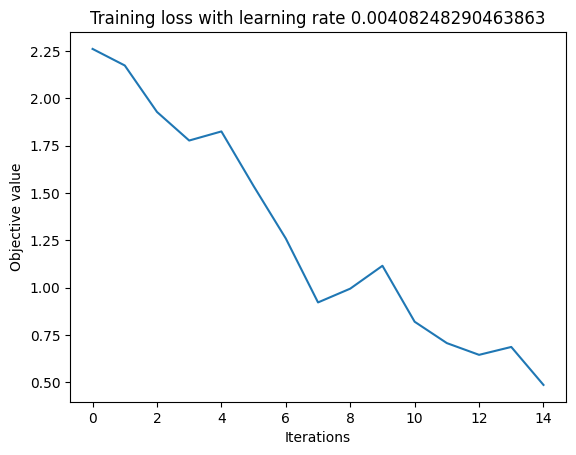

In [69]:
# initialize model
model = build_model()

k = len(x_train)
step_size = 1/np.sqrt(k)

# we adapt SGD in order to answer question 5.2

def SGD_with_tracking(model, x_train, y_train, learning_rate, epochs=1, batch_size=1, track_interval=1000):
    objective_values = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        for i in range(0, len(x_train), batch_size):
            x_train_batch = x_train[i:i+batch_size]
            y_train_batch = y_train[i:i+batch_size]

            # Open a GradientTape to record the operations
            with tf.GradientTape() as tape:
                logits = model(x_train_batch)
                loss_value = loss(y_train_batch, logits)

            grad = tape.gradient(loss_value, model.trainable_weights)
            optimizer = keras.optimizers.SGD(learning_rate)
            optimizer.apply_gradients(zip(grad, model.trainable_variables))

            if i % track_interval == 0:
                objective_values.append(loss_value.numpy())
                print(f"Step {i}/{len(x_train)} - Loss: {loss_value}")


    # Plot the loss over time (epochs)
    plt.plot(range(len(objective_values)), objective_values)
    plt.xlabel("Iterations")
    plt.ylabel("Objective value")
    plt.title(f"Training loss with learning rate {learning_rate}")
    plt.show()


SGD_with_tracking(model, x_train, y_train, step_size, epochs=1, batch_size=32, track_interval=1000)

Epoch 1/1
Step 0/60000 - Loss: 2.391519069671631
Step 4000/60000 - Loss: 2.380591630935669
Step 8000/60000 - Loss: 2.2587168216705322
Step 12000/60000 - Loss: 2.2372827529907227
Step 16000/60000 - Loss: 2.2547643184661865
Step 20000/60000 - Loss: 2.2041852474212646
Step 24000/60000 - Loss: 2.0235300064086914
Step 28000/60000 - Loss: 1.9646705389022827
Step 32000/60000 - Loss: 2.021918773651123
Step 36000/60000 - Loss: 2.0485243797302246
Step 40000/60000 - Loss: 1.8865810632705688
Step 44000/60000 - Loss: 1.8593581914901733
Step 48000/60000 - Loss: 1.7989978790283203
Step 52000/60000 - Loss: 1.726248025894165
Step 56000/60000 - Loss: 1.6901758909225464


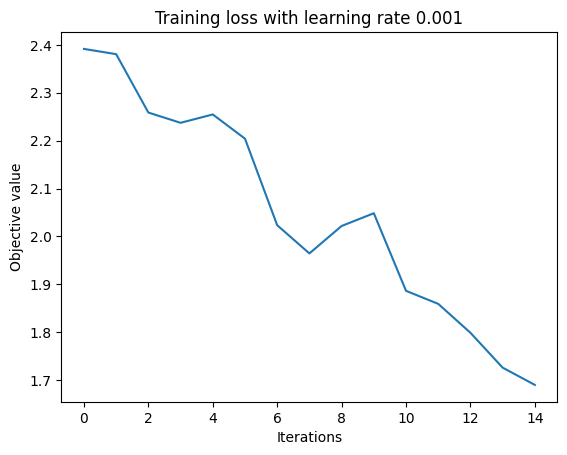

Epoch 1/1
Step 0/60000 - Loss: 2.3216426372528076
Step 4000/60000 - Loss: 2.003416061401367
Step 8000/60000 - Loss: 1.6395493745803833
Step 12000/60000 - Loss: 1.2168203592300415
Step 16000/60000 - Loss: 1.1061809062957764
Step 20000/60000 - Loss: 1.0808098316192627
Step 24000/60000 - Loss: 0.6137341856956482
Step 28000/60000 - Loss: 0.30006933212280273
Step 32000/60000 - Loss: 0.5464463233947754
Step 36000/60000 - Loss: 0.5964013338088989
Step 40000/60000 - Loss: 0.36014121770858765
Step 44000/60000 - Loss: 0.30196279287338257
Step 48000/60000 - Loss: 0.3315701186656952
Step 52000/60000 - Loss: 0.36715248227119446
Step 56000/60000 - Loss: 0.2532857060432434


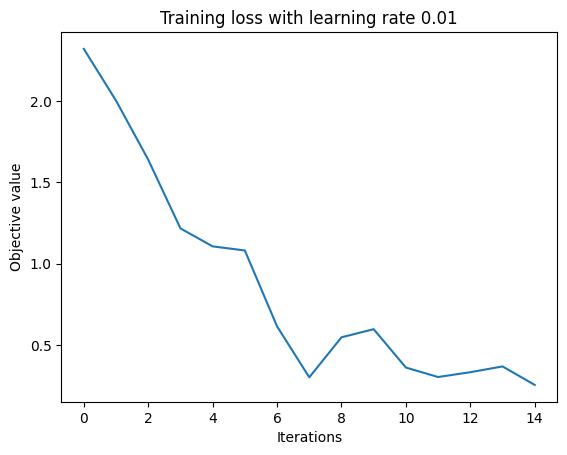

Epoch 1/1
Step 0/60000 - Loss: 2.3494949340820312
Step 4000/60000 - Loss: 0.3033739924430847
Step 8000/60000 - Loss: 0.4330569803714752
Step 12000/60000 - Loss: 0.2098514288663864
Step 16000/60000 - Loss: 0.35985714197158813
Step 20000/60000 - Loss: 0.38175731897354126
Step 24000/60000 - Loss: 0.2068151831626892
Step 28000/60000 - Loss: 0.1481117308139801
Step 32000/60000 - Loss: 0.35263240337371826
Step 36000/60000 - Loss: 0.1805923581123352
Step 40000/60000 - Loss: 0.11863478273153305
Step 44000/60000 - Loss: 0.047256216406822205
Step 48000/60000 - Loss: 0.22854314744472504
Step 52000/60000 - Loss: 0.09990205615758896
Step 56000/60000 - Loss: 0.1806846410036087


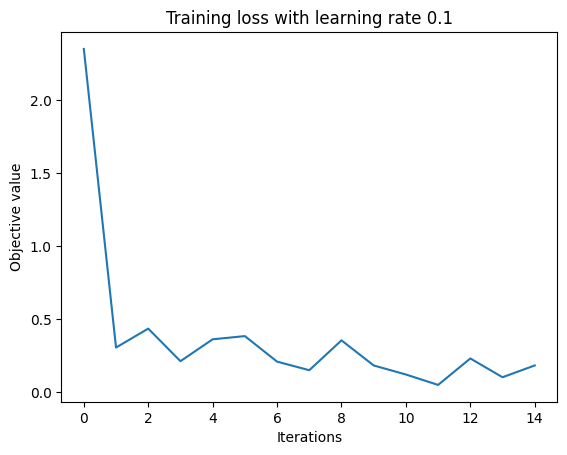

[1.6420492, 0.38124666, 0.20274505]


In [71]:
losses = []
for step_size in [0.001, 0.01, 0.1]:
    model = build_model()
    SGD_with_tracking(model, x_train, y_train, step_size, epochs=1, batch_size=32, track_interval=1000)
    losses.append(mean_loss(model, x_train, y_train))
print(losses)

The best train loss is obtained for the biggest learning rate: 0.1

We could add more epochs to get a better train loss.

# 6. Empirical risk minimization

## Question 6.1

In [73]:
step_size = 0.1
learning_rate = step_size
batch_size = 32

model = build_model()

SGD(model, x_train, y_train, learning_rate, epochs=5, batch_size=batch_size)

train_loss = mean_loss(model, x_train, y_train)
print(f"Loss on training set after 5 epochs: {train_loss}")

Epoch 1/5
Epoch 1/5, Loss: 0.20421285927295685
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Loss on training set after 5 epochs: 0.10759896785020828


Indeed, we improved the train loss by adding more epochs.

## Question 6.2

Mini batching has several advantages.

First, computing the average gradient over a mini-batch reduces the noise caused by individual gradients. Therefore, we gain in efficiency and stability.

Then, compared to full-batch training, mini-batches require less memory, which enables training on large datasets.

## Question 6.3

Epoch 1/4
Step 0/60000 - Loss: 2.309720277786255


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Step 4000/60000 - Loss: 0.41265103220939636
Step 8000/60000 - Loss: 0.4439904987812042
Step 12000/60000 - Loss: 0.2581448256969452
Step 16000/60000 - Loss: 0.24161720275878906
Step 20000/60000 - Loss: 0.5353589653968811
Step 24000/60000 - Loss: 0.16488990187644958
Step 28000/60000 - Loss: 0.29229429364204407
Step 32000/60000 - Loss: 0.060275495052337646
Step 36000/60000 - Loss: 0.14646919071674347
Step 40000/60000 - Loss: 0.12493688613176346
Step 44000/60000 - Loss: 0.1259080022573471
Step 48000/60000 - Loss: 0.1119881272315979
Step 52000/60000 - Loss: 0.13177263736724854
Step 56000/60000 - Loss: 0.20623862743377686
Epoch 2/4
Step 0/60000 - Loss: 0.284507155418396
Step 4000/60000 - Loss: 0.3749881982803345
Step 8000/60000 - Loss: 0.022098662331700325
Step 12000/60000 - Loss: 0.1255744993686676
Step 16000/60000 - Loss: 0.09984003007411957
Step 20000/60000 - Loss: 0.07541010528802872
Step 24000/60000 - Loss: 0.09035470336675644
Step 28000/60000 - Loss: 0.3651593029499054
Step 32000/60000

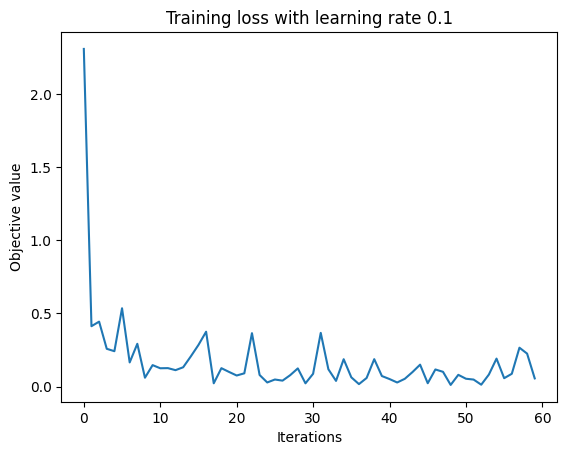

In [93]:
learning_rate = step_size
model = build_model()

def minibatch_SGD(model, x_train, y_train, learning_rate, epochs=1, batch_size=32, track_interval=1000):

    objective_values = []
    num_samples = x_train.shape[0]

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        for i in range(0, len(x_train), batch_size):
            # Select the current batch randomly
            batch_indices = np.random.choice(len(x_train), size=batch_size, replace=False)
            x_train_batch = x_train[batch_indices]
            y_train_batch = y_train[batch_indices]

            # Open a GradientTape to record the operations
            with tf.GradientTape() as tape:
                logits = model(x_train_batch)
                loss_value = loss(y_train_batch, logits)

            grad = tape.gradient(loss_value, model.trainable_weights)
            optimizer = keras.optimizers.SGD(learning_rate)
            optimizer.apply_gradients(zip(grad, model.trainable_variables))

            if i % track_interval == 0:
                objective_values.append(loss_value.numpy())
                print(f"Step {i}/{len(x_train)} - Loss: {loss_value}")

    plt.plot(range(len(objective_values)), objective_values)
    plt.xlabel("Iterations")
    plt.ylabel("Objective value")
    plt.title(f"Training loss with learning rate {learning_rate}")
    plt.show()


minibatch_SGD(model, x_train, y_train, learning_rate, epochs=4, batch_size=32, track_interval=1000)

It is clear the mini-batch stochastic gradient descent converges a lot faster.

# 7. Evaluation of the model

# Question 7.1



In [97]:
(train_images, train_labels), (test_images,
                               test_labels) = tf.keras.datasets.mnist.load_data()

# Preprocess
train_images = train_images.reshape(-1, 784).astype('float32') / 255
test_images = test_images.reshape(-1, 784).astype('float32') / 255

In [99]:
model = build_model()
SGD(model, x_train, y_train, learning_rate, epochs=1, batch_size=32)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10, batch_size=32, verbose=1)

train_loss, train_acc = model.evaluate(train_images, train_labels)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print(f"Train accuracy of SGD: {train_acc}, Test accuracy of SGD: {test_acc}")

Epoch 1/1
Epoch 1/1, Loss: 0.18449603021144867
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9516 - loss: 0.1631
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9653 - loss: 0.1152
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9719 - loss: 0.0953
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9755 - loss: 0.0789
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9791 - loss: 0.0686
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9810 - loss: 0.0594
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9812 - loss: 0.0567
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9853 - loss: 0.0467
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9858 - loss: 0.0459
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9872 - loss: 0.0408
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9907 - loss: 0

Epoch 1/1
Step 0/60000 - Loss: 2.3676564693450928
Step 4000/60000 - Loss: 0.30887600779533386
Step 8000/60000 - Loss: 0.9856448769569397
Step 12000/60000 - Loss: 0.3540174961090088
Step 16000/60000 - Loss: 0.2490096390247345
Step 20000/60000 - Loss: 0.29055842757225037
Step 24000/60000 - Loss: 0.1925574541091919
Step 28000/60000 - Loss: 0.31160232424736023
Step 32000/60000 - Loss: 0.1883126199245453
Step 36000/60000 - Loss: 0.18276947736740112
Step 40000/60000 - Loss: 0.3214968740940094
Step 44000/60000 - Loss: 0.2529893219470978
Step 48000/60000 - Loss: 0.22682702541351318
Step 52000/60000 - Loss: 0.29518595337867737
Step 56000/60000 - Loss: 0.32347041368484497


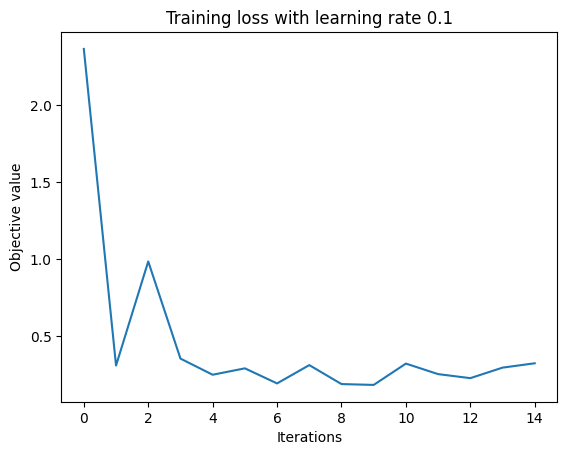

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9510 - loss: 0.1652
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9646 - loss: 0.1184
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9735 - loss: 0.0904
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9764 - loss: 0.0761
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9791 - loss: 0.0693
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9811 - loss: 0.0604
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9823 - loss: 0.0542
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9834 - loss: 0.0513
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9854 - loss: 0.0444
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9870 - loss: 0.0383
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9890 - loss: 0.0361
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [100]:
model = build_model()
minibatch_SGD(model, x_train, y_train, learning_rate, epochs=1, batch_size=32, track_interval=1000)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10, batch_size=32, verbose=1)

train_loss, train_acc = model.evaluate(train_images, train_labels)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print(f"Train accuracy of mini-batch SGD: {train_acc}, Test accuracy of mini-batch SGD: {test_acc}")

We obtain excellent accuraty in both cases.